# Credit Scoring

O negócio bancário tem como principal know-how a capacidade de gerenciamento de risco financeiro. O cálculo da taxa de inadimplência de um carteira de crédito desempenha papel fundamental no desempenho e planejamento de uma instituição financeira.

O objetivo destes cálculos é identificar a probabilidade de um cliente entrar em default que é o não cumprimento de uma obrigação ou condição de um empréstimo, sendo que normalmente sua causa é a incapacidade financeira do cliente.

Instituições pelo mundo têm incorporado o uso de modelos de machine learning para o aprimoramento de sua avaliação de risco. Neste contexto, temos uma base de dados da fintech Nubank que será utilizada para modelagem afim de predizer a probabilidade de default para seus clientes.

# Importando Libs

In [1]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# importar algoritmos e metricas
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import ks_2samp
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import GridSearchCV, cross_validate

import xgboost as xgb

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:,.2f}".format

In [2]:
db = pd.read_csv("http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0")

# Prévia dos dados

In [3]:
print(db.head().to_string())

                                    ids target_default                   score_1                   score_2  score_3  score_4  score_5  score_6  risk_rate  last_amount_borrowed  last_borrowed_in_months  credit_limit                                                                                                                            reason     income facebook_profile                     state                       zip                   channel                                                                                                      job_name                real_state  ok_since  n_bankruptcies  n_defaulted_loans  n_accounts  n_issues application_time_applied  application_time_in_funnel        email  external_data_provider_credit_checks_last_2_year  external_data_provider_credit_checks_last_month  external_data_provider_credit_checks_last_year  external_data_provider_email_seen_before external_data_provider_first_name  external_data_provider_fraud_score                      

In [4]:
print(80*'*')
print(f'Dimensões: {db.shape[0]} linhas e {db.shape[1]} colunas.\n')
print(80*'*')
print(f'Colunas: {db.columns.values}\n')
print(80*'*')
print('Tipos:', '\n\n'+str(db.dtypes)+'\n')
print(80*'*')
print('Quantidade de valores únicos: ', '\n\n'+str(db.nunique().sort_values()))
print('\n'+80*'*')
print('Prévia dos valores: \n')
for col in db.columns.values:
  if len(db[col].unique()) > 5:
    print('\n'+col+': ', db[col].unique()[:5], 'entre outros...')
  else:
    print('\n'+col+': ', db[col].unique())
print('\n'+80*'*')
print('Estatística Descritiva: \n\n', db.describe().to_string(max_cols=db.shape[1]))
print('\n'+80*'*')
num_but_cat = [col for col in db.columns if db[col].nunique() < 10 and db[col].dtypes != "O"]
cat_but_car = [col for col in db.columns if db[col].nunique() > 20 and db[col].dtypes == "O"]
print('Variáveis numéricas que podem ser categoricas: ', num_but_cat)
print('Variáveis categóricas com cardinalidade: ', cat_but_car)

********************************************************************************
Dimensões: 45000 linhas e 43 colunas.

********************************************************************************
Colunas: ['ids' 'target_default' 'score_1' 'score_2' 'score_3' 'score_4' 'score_5'
 'score_6' 'risk_rate' 'last_amount_borrowed' 'last_borrowed_in_months'
 'credit_limit' 'reason' 'income' 'facebook_profile' 'state' 'zip'
 'channel' 'job_name' 'real_state' 'ok_since' 'n_bankruptcies'
 'n_defaulted_loans' 'n_accounts' 'n_issues' 'application_time_applied'
 'application_time_in_funnel' 'email'
 'external_data_provider_credit_checks_last_2_year'
 'external_data_provider_credit_checks_last_month'
 'external_data_provider_credit_checks_last_year'
 'external_data_provider_email_seen_before'
 'external_data_provider_first_name' 'external_data_provider_fraud_score'
 'lat_lon' 'marketing_channel' 'profile_phone_number' 'reported_income'
 'shipping_state' 'shipping_zip_code' 'profile_tags' 'user_ag


reported_income:  [ 57849.   4902. 163679.   1086. 198618.] entre outros...

shipping_state:  ['BR-MT' 'BR-RS' 'BR-RR' 'BR-RN' 'BR-SP'] entre outros...

shipping_zip_code:  [17528 40933 50985 37825 52827] entre outros...

profile_tags:  ["{'tags': ['n19', 'n8']}" "{'tags': ['n6', 'n7', 'nim']}"
 "{'tags': ['n0', 'n17', 'nim', 'da']}" "{'tags': ['n4']}"
 "{'tags': ['pro+aty', 'n19', 'da', 'b19']}"] entre outros...

user_agent:  ['Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Build/32.2.A.0.253; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/52.0.2743.98 Safari/537.368'
 'Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-T550 Build/LRX22G) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/3.3 Chrome/38.0.2125.102 Safari/537.36'
 'Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Build/32.2.A.0.253; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/52.0.2743.98 Safari/537.363'
 'Mozilla/5.0 (Linux; Android 6.0; HTC One X10 Build/MRA58K; wv) AppleWebKit/537.36 (KHTML, like 

# Sumário

O dataset possui `45000 linhas e 43 colunas`.

A variável target para risco de default está armazenada na coluna `target_default`. Também temos uma variável target para o escopo de um projeto de verificação de fraude `'target_fraud'`

A base de dados possui features de cadastro de cliente, são elas: <br>
* `ids, reason, state, zip, channel, job_name, real_state, facebook_profile, email, shipping_state, shipping_zip_code,profile_phone_number,profile_tags, income, reported_income, marketing_channel`

Features relacionadas a análise de crédito:
* `score_1, score_2, score_3,score_4, score_5, score_6, risk_rate, last_amount_borrowed, last_borrowed_in_months, credit_limit, n_bankruptcies, n_defaulted_loans, n_accounts, n_issues, external_data_provider_credit_checks_last_2_year, external_data_provider_credit_checks_last_month, external_data_provider_credit_checks_last_year, external_data_provider_fraud_score`

Alguns dados de telemetria:
* `user_agent, application_time_applied, application_time_in_funnel`

As variáveis abaixo demandam aprofundamento em sua sistemática para compreensão da informação:

* `ok_since, external_data_provider_email_seen_before, external_data_provider_first_name, lat_lon`

Pontos de Atenção
- A feature `external_data_provider_credit_checks_last_2_year` e `channel` possuem somente um valor único, assim consideraremos estas features inválidas para treinamento dada variância inexistente.

- `reported_income` apresenta valores infinitos que serão removidos da amostra.

- `external_data_provider_email_seen_before` possui valor -999 que pode indicar um valor inválido.


# Missing / Nulos



* `ok_since` possui > 58% de valores ausentes e sendo numérica não podemos considerar sua ausência uma classe. Neste contexto esta feature será retirada do treinamento do modelo.

* `external_data_provider_credit_checks_last_2_year` seria dropada dado que só existem valores 0, caso a ausência fosse considerada também False (0) manteríamos o mesmo problema. Esta feature será desconsiderada.

* `external_data_provider_credit_checks_last_year, last_amount_borrowed, last_borrowed_in_months, credit_limit, n_issues, facebook_profile` possuem grande parcela de dados ausentes, no entanto podemos considerar esta ausência como 0 ou False para estas features, agregando valor para esta informação.


* Excluiremos registros que possuem valores para as demais features com valor ausentes.

In [5]:
print('Valores Nulos:', '\n\n'+str((db.isnull().sum()/db.shape[0]).sort_values(ascending=False))+'\n\n')

Valores Nulos: 

target_fraud                                       0.97
last_amount_borrowed                               0.67
last_borrowed_in_months                            0.67
ok_since                                           0.59
external_data_provider_credit_checks_last_2_year   0.50
external_data_provider_credit_checks_last_year     0.34
credit_limit                                       0.31
n_issues                                           0.26
facebook_profile                                   0.10
marketing_channel                                  0.08
job_name                                           0.07
target_default                                     0.07
external_data_provider_email_seen_before           0.05
lat_lon                                            0.03
user_agent                                         0.02
n_bankruptcies                                     0.02
n_defaulted_loans                                  0.01
reason                         

# Features Selecionadas

Considerando a informação contida e sua utilidade removeremos as seguintes colunas:

*   Features cadastrais/contato de clientes/com cardinalidade: <br>
`ids, profile_phone_number, email, reason, state, real_state, zip, channel, job_name`

*   Telemetria: <br>
`user_agent, application_time_applied, application_time_in_funnel`

* Missing e Nulos: <br>
`ok_since, external_data_provider_credit_checks_last_2_year`

*   Demandam maior aprofundamento: <br>
`external_data_provider_email_seen_before, external_data_provider_first_name, profile_tags`

* Escopo de detecção de fraude: <br>
`target_fraud, external_data_provider_fraud_score, lat_lon, shipping_state, shipping_zip_code`

Teremos então as seguintes features para o treinamento do modelo:

* `credit_limit`: Limite de crédito.

* `external_data_provider_credit_checks_last_month`: Quantidade de checagens no bureau de crédito no último mês.

* `external_data_provider_credit_checks_last_year`: Quantidade de checagens no bureau de crédito no último ano.

* `facebook_profile`: Perfil do facebook conhecido/informado.

* `income`: Renda.

* `last_amount_borrowed`: Último valor emprestado.

* `last_borrowed_in_months`: Quantos meses do último empréstimo.

* `marketing_channel`: Canal de marketing utilizado na oferta.

* `n_bankruptcies`: quantidade de falências/defaults.

* `n_defaulted_loans`: Quantidade de empréstimos com default.

* `n_accounts`: Número de contas.

* `n_issues`: Número de solicitações de crédito.

* `reported_income`: Renda informada pelo cliente.

* `risk_rate`: proporção de risco (?)

* `score_1, score_2, score_3, score_4, score_5, score_6`: Outros scores de crédito.

In [6]:
df = db[['target_default', 'credit_limit', 'external_data_provider_credit_checks_last_month', 'external_data_provider_credit_checks_last_year', 'facebook_profile', 'income', 'last_amount_borrowed', 'last_borrowed_in_months', 'marketing_channel', 'n_bankruptcies', 'n_defaulted_loans',
        'n_accounts', 'n_issues', 'reported_income', 'risk_rate', 'score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6']].copy()

print(df.head().to_string(max_cols=df.shape[1]))

  target_default  credit_limit  external_data_provider_credit_checks_last_month  external_data_provider_credit_checks_last_year facebook_profile     income  last_amount_borrowed  last_borrowed_in_months marketing_channel  n_bankruptcies  n_defaulted_loans  n_accounts  n_issues  reported_income  risk_rate                   score_1                   score_2  score_3  score_4  score_5  score_6
0          False          0.00                                                2                                            0.00             True  65,014.12             25,033.92                    36.00      Invite-email            0.00               0.00       18.00     18.00        57,849.00       0.40  1Rk8w4Ucd5yR3KcqZzLdow==  IOVu8au3ISbo6+zmfnYwMg==   350.00   101.80     0.26   108.43
1          False     39,726.00                                                1                                            0.00            False 100,018.91                   NaN                      NaN  Radio-co

# Data Cleaning

In [7]:
df_clean = df.copy()

#Preencheremos valores 0 para nulos.
df_clean['last_amount_borrowed'].fillna(value=0, inplace=True)
df_clean['last_borrowed_in_months'].fillna(value=0, inplace=True)
df_clean['external_data_provider_credit_checks_last_year'].fillna(value=0, inplace=True)
df_clean['credit_limit'].fillna(value=0, inplace=True)
df_clean['n_issues'].fillna(value=0, inplace=True)
df_clean['n_bankruptcies'].fillna(value=0, inplace=True)
df_clean['n_defaulted_loans'].fillna(value=0, inplace=True)
df_clean['facebook_profile'].fillna(value=False, inplace=True)

#Tratando valores inf para remoção.
df_clean['reported_income'] = df_clean['reported_income'].replace(np.inf, np.nan)

#Excluindo registros com valores ausentes para a target.
df_clean = df_clean.dropna(subset=['target_default'], inplace=False)

rows=df_clean.shape[0]
df_clean = df_clean.dropna()
print(f'Missing/Nulos: {rows - df_clean.shape[0]} linhas excluídas.(', 1-(df_clean.shape[0]/rows), '%)')

Missing/Nulos: 3367 linhas excluídas.( 0.0806640952540667 %)


# Features x Target

In [8]:
def val_count_views(col):
  df = pd.concat([col.value_counts(normalize=True, dropna=False),
                  col.value_counts(dropna=False)],
                  axis=1,
                  keys=('perc','count'))

  return df

In [9]:
val_count_views(df_clean['target_default'])

,perc,count
False,0.84,32246
True,0.16,6128


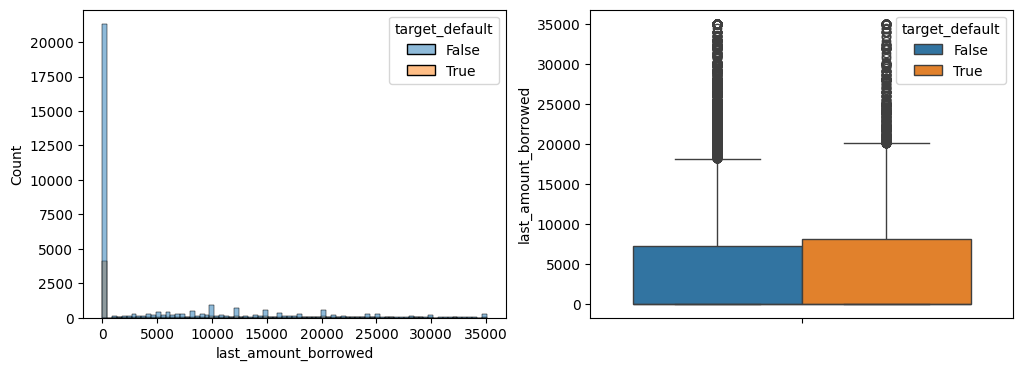

In [10]:
fig, axis = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(data=df_clean, x='last_amount_borrowed', hue='target_default', ax=axis[0])
sns.boxplot(data=df_clean, y='last_amount_borrowed', hue='target_default', ax=axis[1])
plt.show()

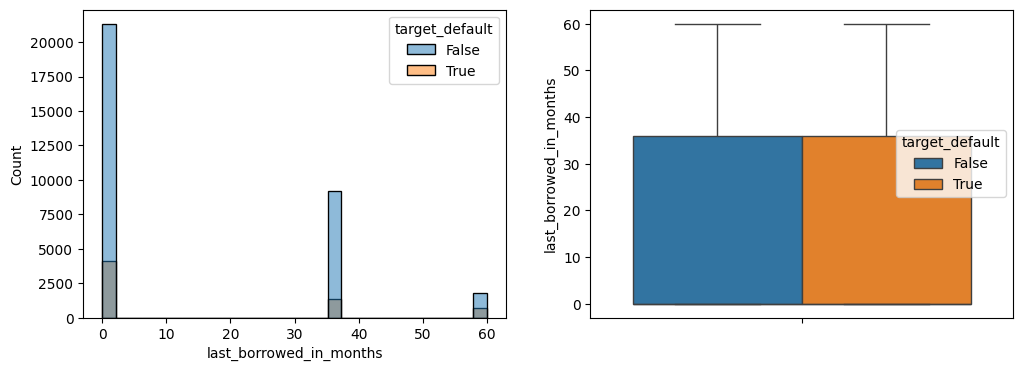

In [11]:
fig, axis = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(data=df_clean, x='last_borrowed_in_months', hue='target_default', ax=axis[0])
sns.boxplot(data=df_clean, y='last_borrowed_in_months', hue='target_default', ax=axis[1])
plt.show()

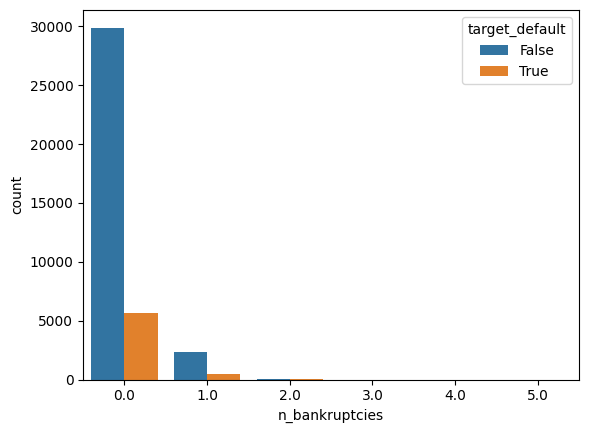

In [12]:
sns.countplot(data=df_clean, x='n_bankruptcies', hue='target_default')
plt.show()

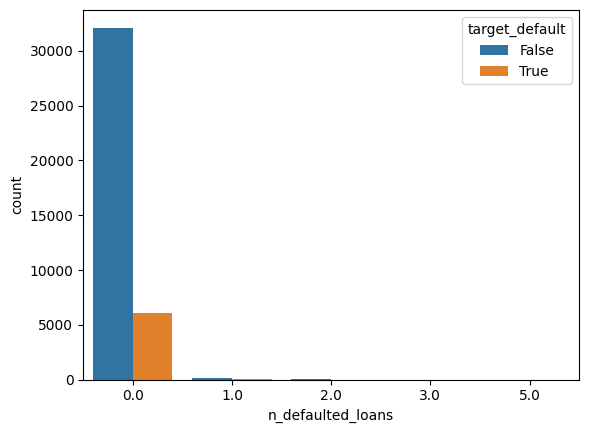

In [13]:
sns.countplot(data=df_clean, x='n_defaulted_loans', hue='target_default')
plt.show()

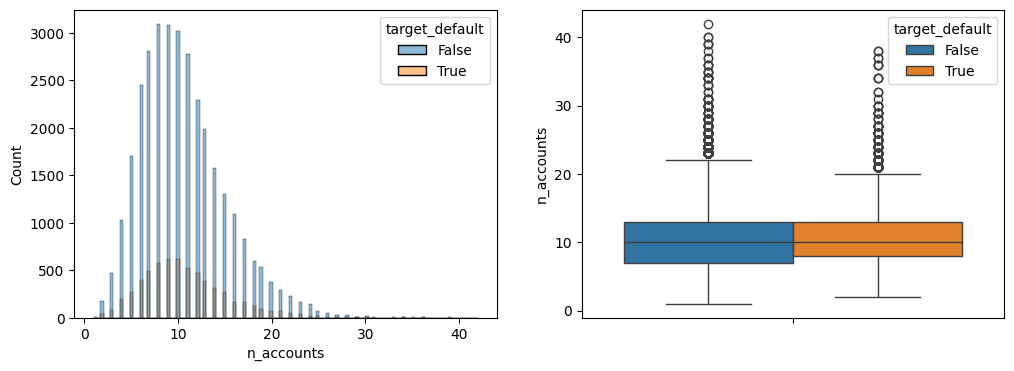

In [14]:
fig, axis = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(data=df_clean, x='n_accounts', hue='target_default', ax=axis[0])
sns.boxplot(data=df_clean, y='n_accounts', hue='target_default', ax=axis[1])
plt.show()

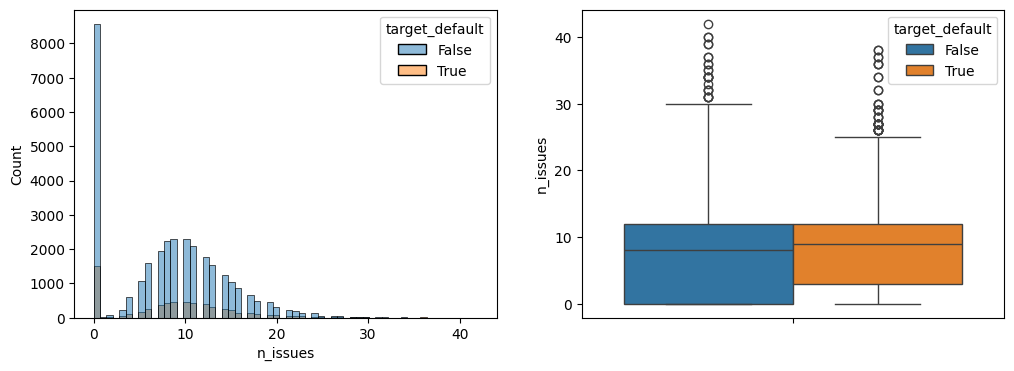

In [15]:
fig, axis = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(data=df_clean, x='n_issues', hue='target_default', ax=axis[0])
sns.boxplot(data=df_clean, y='n_issues', hue='target_default', ax=axis[1])
plt.show()

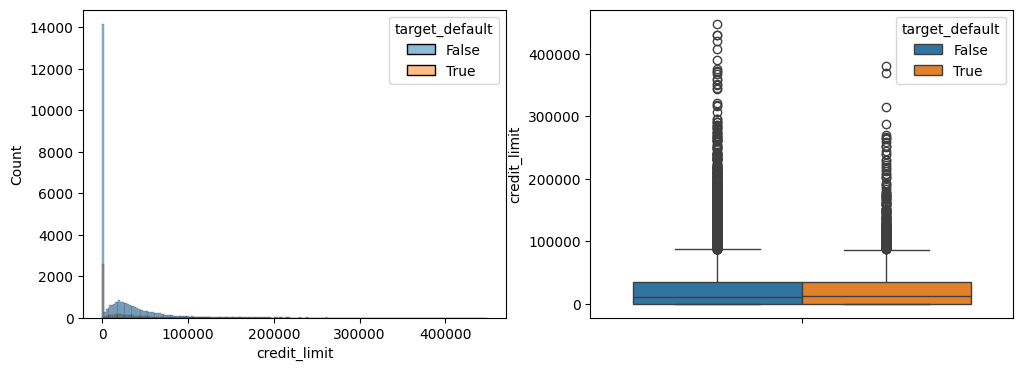

In [16]:
fig, axis = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(data=df_clean, x='credit_limit', hue='target_default', ax=axis[0])
sns.boxplot(data=df_clean, y='credit_limit', hue='target_default', ax=axis[1])
plt.show()

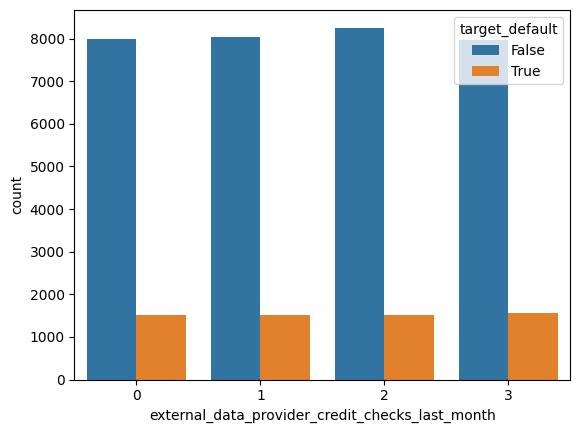

In [17]:
sns.countplot(data=df_clean, x='external_data_provider_credit_checks_last_month', hue='target_default')
plt.show()

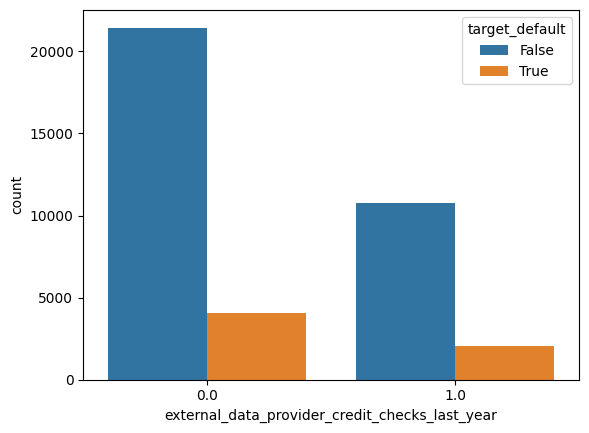

In [18]:
sns.countplot(data=df_clean, x='external_data_provider_credit_checks_last_year', hue='target_default')
plt.show()

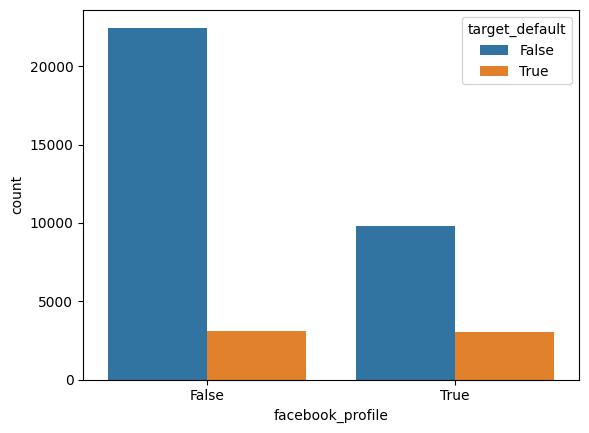

In [19]:
sns.countplot(data=df_clean, x='facebook_profile', hue='target_default')
plt.show()



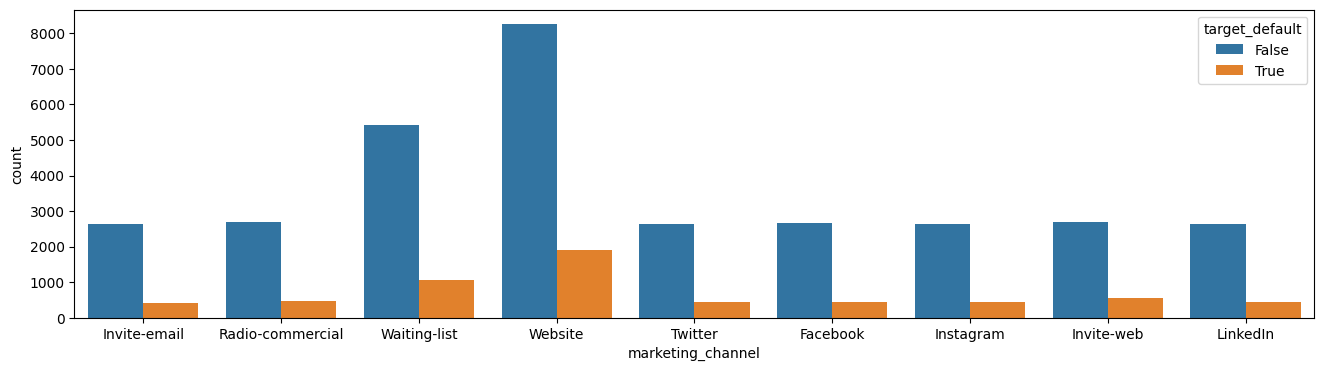

In [20]:
fig, axis = plt.subplots(figsize=(16,4))
sns.countplot(data=df_clean, x='marketing_channel', hue='target_default')
plt.show()

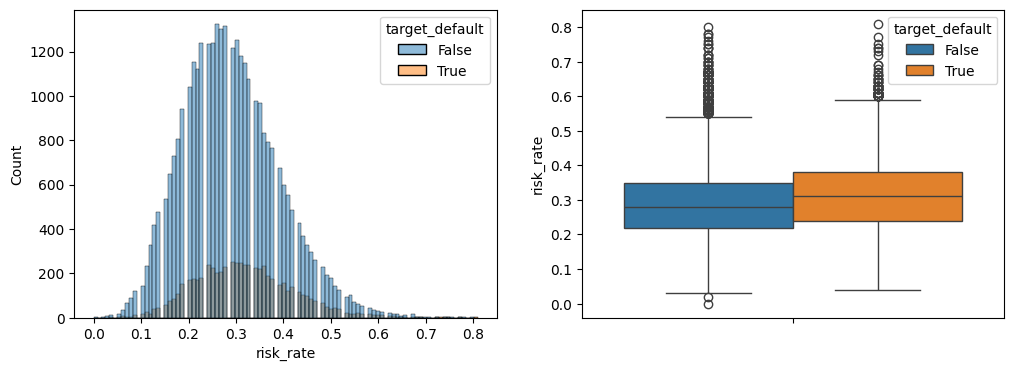

In [21]:
fig, axis = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(data=df_clean, x='risk_rate', hue='target_default', ax=axis[0])
sns.boxplot(data=df_clean, y='risk_rate', hue='target_default', ax=axis[1])
plt.show()

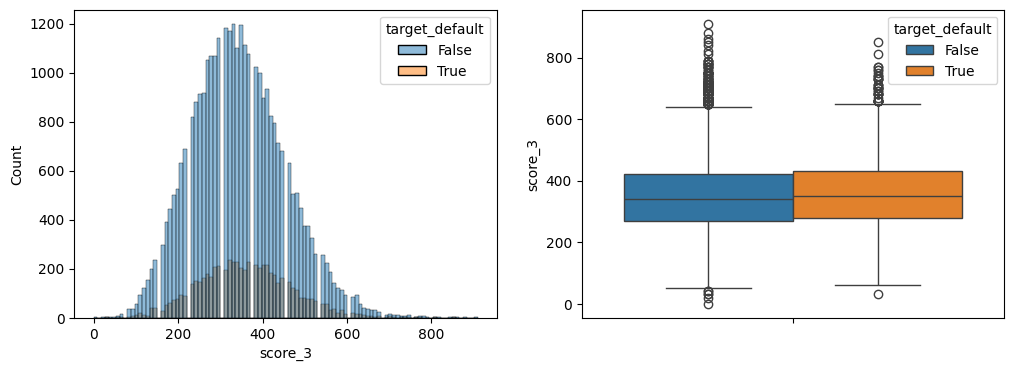

In [22]:
fig, axis = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(data=df_clean, x='score_3', hue='target_default', ax=axis[0])
sns.boxplot(data=df_clean, y='score_3', hue='target_default', ax=axis[1])
plt.show()

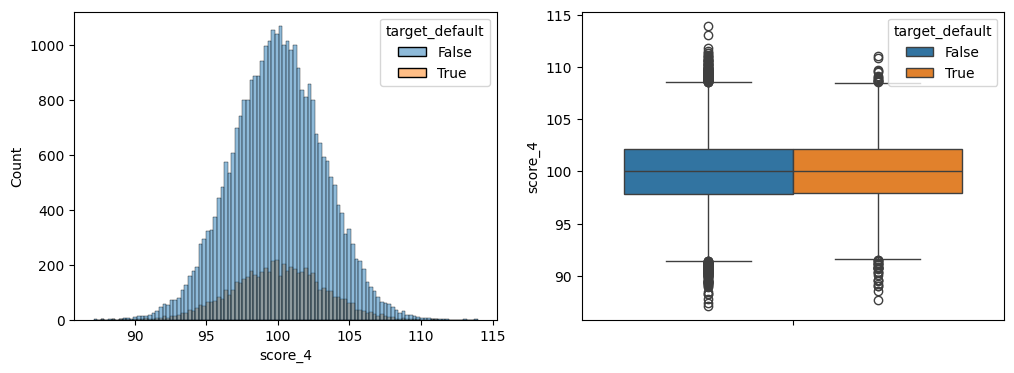

In [23]:
fig, axis = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(data=df_clean, x='score_4', hue='target_default', ax=axis[0])
sns.boxplot(data=df_clean, y='score_4', hue='target_default', ax=axis[1])
plt.show()

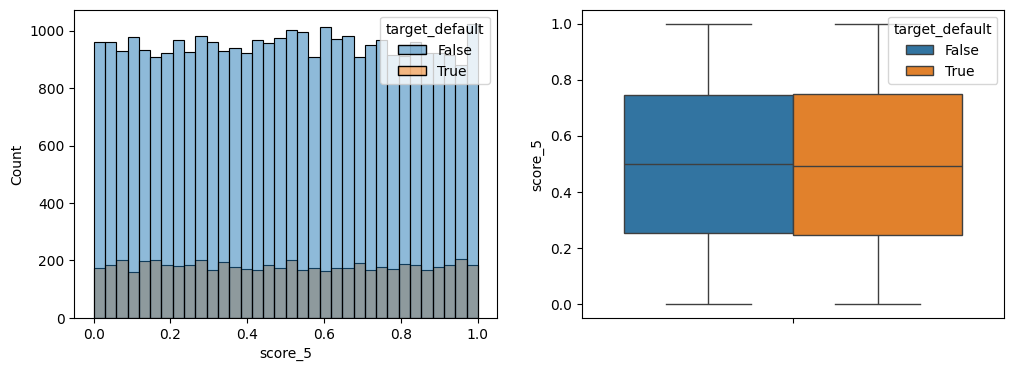

In [24]:
fig, axis = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(data=df_clean, x='score_5', hue='target_default', ax=axis[0])
sns.boxplot(data=df_clean, y='score_5', hue='target_default', ax=axis[1])
plt.show()

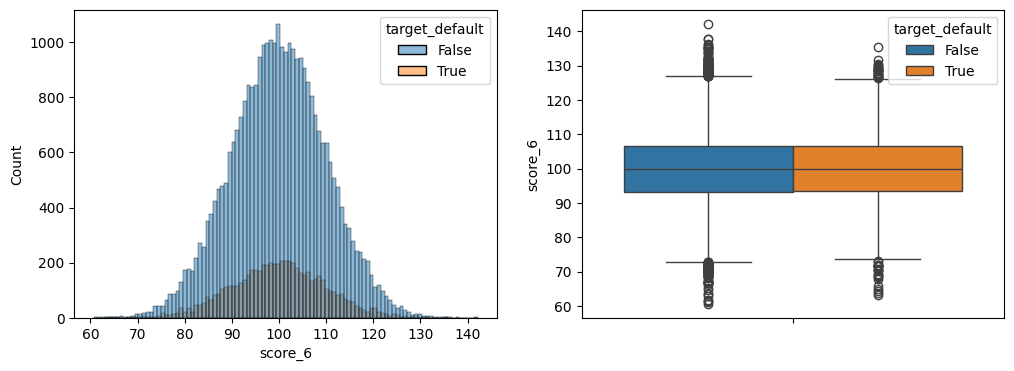

In [25]:
fig, axis = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(data=df_clean, x='score_6', hue='target_default', ax=axis[0])
sns.boxplot(data=df_clean, y='score_6', hue='target_default', ax=axis[1])
plt.show()

## Outliers

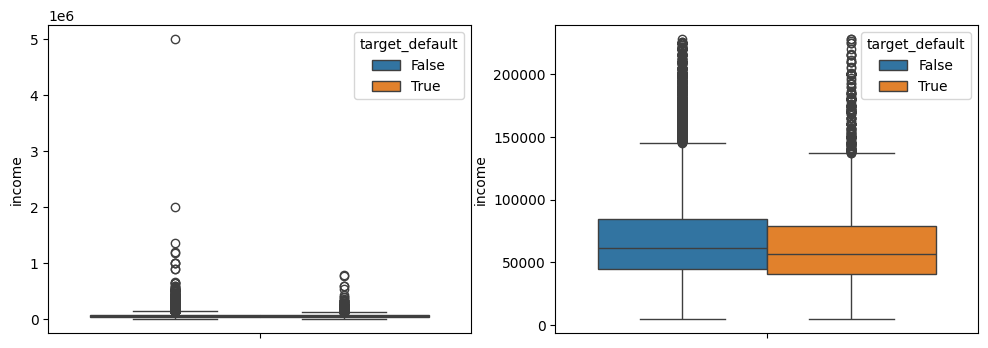

In [26]:
outlier_limit = df_clean['income'].mean() + (3*df_clean['income'].std())

fig, axis = plt.subplots(ncols=2, figsize=(12,4))
sns.boxplot(data=df_clean, y='income', hue='target_default', ax=axis[0])
sns.boxplot(data=df_clean.loc[df_clean['income'] < outlier_limit], y='income', hue='target_default', ax=axis[1])
plt.show()

In [27]:
df_clean = df_clean.loc[df_clean['income'] < outlier_limit]

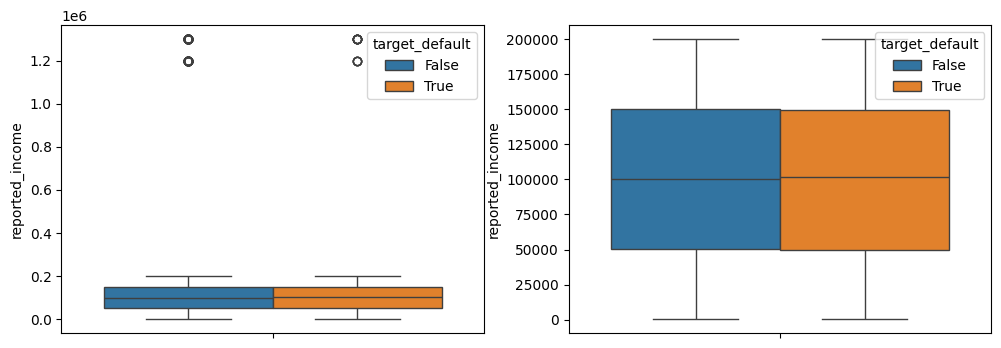

In [28]:
df_clean = df_clean.loc[df_clean['reported_income'] < 1e7]
outlier_limit = df_clean['reported_income'].mean() + (3*df_clean['reported_income'].std())

fig, axis = plt.subplots(ncols=2, figsize=(12,4))
sns.boxplot(data=df_clean, y='reported_income', hue='target_default', ax=axis[0])
sns.boxplot(data=df_clean.loc[df_clean['reported_income'] < outlier_limit], y='reported_income', hue='target_default', ax=axis[1])
plt.show()

In [29]:
df_clean = df_clean.loc[df_clean['reported_income'] < outlier_limit]

## Scores codificados

As features `score_1`e `score_2` apresentam categorias codificadas, assumindo que se trata de um score de crédito podemos ordenar estas categorias e renomear conforme o % de clientes com target igual a True.

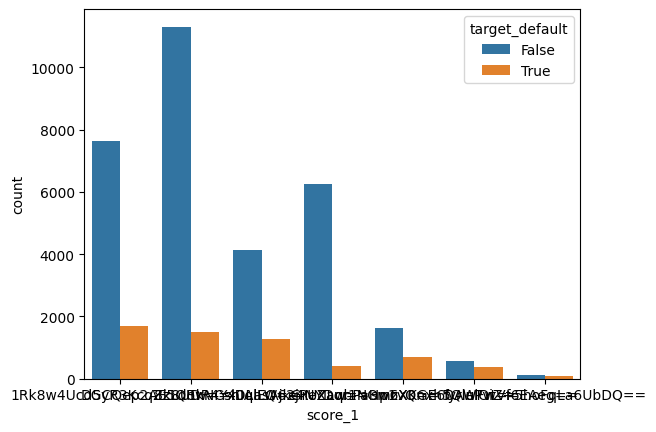

In [30]:
sns.countplot(data=df_clean, x='score_1', hue='target_default')
plt.show()

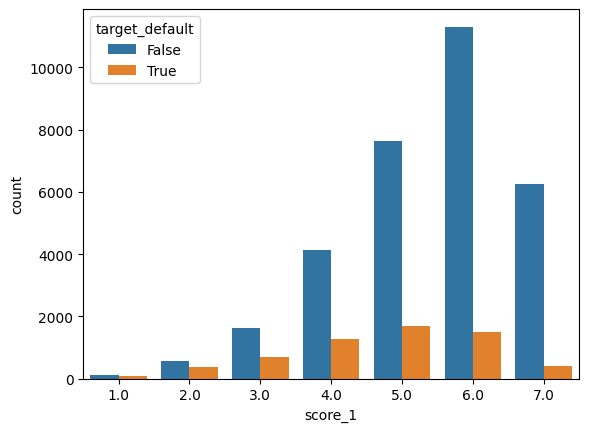

In [31]:
ordered_score_1 = df_clean.groupby('score_1', as_index=False)['target_default'].mean().sort_values(by='target_default', ascending=False)['score_1']

i=1
for score in ordered_score_1:
    df_clean.loc[df_clean['score_1'] == score, 'score_1'] = i
    i+=1

df_clean['score_1'] = df_clean['score_1'].astype(np.float64)
    
sns.countplot(data=df_clean, x='score_1', hue='target_default')
plt.show()

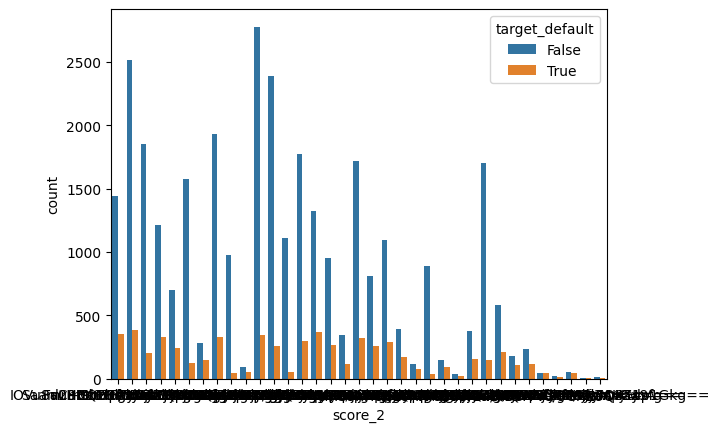

In [32]:
sns.countplot(data=df_clean, x='score_2', hue='target_default')
plt.show()

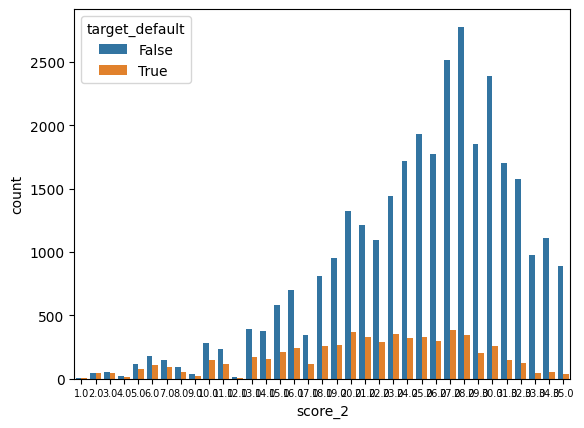

In [33]:
ordered_score_2 = df_clean.groupby('score_2', as_index=False)['target_default'].mean().sort_values(by='target_default', ascending=False)['score_2']

i=1
for score in ordered_score_2:
    df_clean.loc[df_clean['score_2'] == score, 'score_2'] = i
    i+=1

df_clean['score_2'] = df_clean['score_2'].astype(np.float64)
    
sns.countplot(data=df_clean, x='score_2', hue='target_default')
plt.xticks(size=7)
plt.show()

# Padronizando os dados

In [34]:
print(df_clean.head().to_string())

  target_default  credit_limit  external_data_provider_credit_checks_last_month  external_data_provider_credit_checks_last_year  facebook_profile     income  last_amount_borrowed  last_borrowed_in_months marketing_channel  n_bankruptcies  n_defaulted_loans  n_accounts  n_issues  reported_income  risk_rate  score_1  score_2  score_3  score_4  score_5  score_6
0          False          0.00                                                2                                            0.00              True  65,014.12             25,033.92                    36.00      Invite-email            0.00               0.00       18.00     18.00        57,849.00       0.40     5.00    23.00   350.00   101.80     0.26   108.43
1          False     39,726.00                                                1                                            0.00             False 100,018.91                  0.00                     0.00  Radio-commercial            0.00               0.00       14.00     14.00

In [35]:
encoded_df = df_clean.copy()

# normalizar as colunas numéricas
num_cols = ['target_default', 'credit_limit', 'external_data_provider_credit_checks_last_month', 'external_data_provider_credit_checks_last_year', 'facebook_profile', 'income', 'last_amount_borrowed', 'last_borrowed_in_months', 'n_bankruptcies', 'n_defaulted_loans',
        'n_accounts', 'n_issues', 'reported_income', 'risk_rate', 'score_3', 'score_4', 'score_5', 'score_6']

encoded_df[num_cols] = MinMaxScaler().fit_transform(encoded_df[num_cols].values)

# extrair as colunas categóricas
ohe_list = ['marketing_channel']
ohe = OneHotEncoder()
ohe.fit(encoded_df[ohe_list])
ohe_new_list = ohe.get_feature_names_out(ohe_list)
df_ohe = pd.DataFrame(ohe.transform(encoded_df[ohe_list]).toarray(),columns=ohe_new_list,index=encoded_df.index)
other_columns = [ft for ft in encoded_df.columns if ft not in ohe_list]
encoded_df = pd.concat([encoded_df[other_columns], df_ohe],axis=1)

print(encoded_df.head().to_string())

   target_default  credit_limit  external_data_provider_credit_checks_last_month  external_data_provider_credit_checks_last_year  facebook_profile  income  last_amount_borrowed  last_borrowed_in_months  n_bankruptcies  n_defaulted_loans  n_accounts  n_issues  reported_income  risk_rate  score_1  score_2  score_3  score_4  score_5  score_6  marketing_channel_Facebook  marketing_channel_Instagram  marketing_channel_Invite-email  marketing_channel_Invite-web  marketing_channel_LinkedIn  marketing_channel_Radio-commercial  marketing_channel_Twitter  marketing_channel_Waiting-list  marketing_channel_Website
0            0.00          0.00                                             0.67                                            0.00              1.00    0.27                  0.71                     0.60            0.00               0.00        0.41      0.43             0.29       0.49     5.00    23.00     0.38     0.55     0.26     0.59                        0.00                      

# IV e VIF

In [36]:
def show_VIF(df, feature_cols):
  # the independent variables set
  X = df[feature_cols].copy()
  X['intercept'] = 1

  # VIF dataframe
  vif_data = pd.DataFrame()
  vif_data["feature"] = X.columns

  # calculating VIF for each feature
  vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

  vif_data = vif_data.sort_values(by='VIF', ascending=False)

  print("\n", vif_data)

In [37]:
feature_cols = list(encoded_df.drop(['target_default'], axis=1).columns)

In [38]:
show_VIF(encoded_df,feature_cols)


                                             feature   VIF
19                       marketing_channel_Facebook   inf
27                        marketing_channel_Website   inf
26                   marketing_channel_Waiting-list   inf
25                        marketing_channel_Twitter   inf
24               marketing_channel_Radio-commercial   inf
23                       marketing_channel_LinkedIn   inf
22                     marketing_channel_Invite-web   inf
21                   marketing_channel_Invite-email   inf
20                      marketing_channel_Instagram   inf
14                                          score_2 13.11
13                                          score_1 13.08
5                              last_amount_borrowed  3.65
6                           last_borrowed_in_months  3.56
10                                         n_issues  2.20
9                                        n_accounts  1.87
0                                      credit_limit  1.53
4           

Considerando VIF > 5 para sinais de multicolinearidade, verificamos que `score_1` e `score_2` apresentam problemas de multicolinearidade. Retirando um deles temos VIFs razoáveis.

In [39]:
temp_feats = feature_cols.copy()
temp_feats.remove('score_1')
show_VIF(encoded_df,temp_feats)


                                             feature  VIF
23               marketing_channel_Radio-commercial  inf
24                        marketing_channel_Twitter  inf
20                   marketing_channel_Invite-email  inf
21                     marketing_channel_Invite-web  inf
22                       marketing_channel_LinkedIn  inf
18                       marketing_channel_Facebook  inf
19                      marketing_channel_Instagram  inf
25                   marketing_channel_Waiting-list  inf
26                        marketing_channel_Website  inf
5                              last_amount_borrowed 3.65
6                           last_borrowed_in_months 3.56
10                                         n_issues 2.20
9                                        n_accounts 1.87
0                                      credit_limit 1.53
4                                            income 1.25
13                                          score_2 1.20
12                           

In [40]:
def iv_woe(data, target, bins=10, show_woe=False):

    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [round(d['IV'].sum(), 4)]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

    newDF['Level'] = 'Very Weak'
    newDF.loc[(newDF['IV'] > 0.02) & (newDF['IV'] < 0.1), 'Level'] = 'Weak'
    newDF.loc[(newDF['IV'] > 0.1) & (newDF['IV'] < 0.3), 'Level'] = 'Average'
    newDF.loc[(newDF['IV'] > 0.3) & (newDF['IV'] < 0.5), 'Level'] = 'Strong'
    newDF.loc[(newDF['IV'] > 0.5), 'Level'] = 'Suspicious'

    newDF = newDF.sort_values(by='IV', ascending=False)
    #Show WOE Table
    if show_woe == True:
        print("\n", newDF)

    return newDF, woeDF

In [41]:
newDF, woeDF = iv_woe(encoded_df, 'target_default', bins=100, show_woe=True)


                                           Variable   IV      Level
0                                          score_2 0.38     Strong
0                                          score_1 0.35     Strong
0                                 facebook_profile 0.16    Average
0                                        risk_rate 0.09       Weak
0                          last_borrowed_in_months 0.07       Weak
0                                           income 0.05       Weak
0                                          score_3 0.03       Weak
0                                  reported_income 0.02       Weak
0                                          score_5 0.02       Weak
0                                          score_6 0.02       Weak
0                             last_amount_borrowed 0.02  Very Weak
0                                          score_4 0.02  Very Weak
0                        marketing_channel_Website 0.01  Very Weak
0                                         n_issues 0.01  Ver

Após o ajuste nos scores 1 e 2 temos duas features com IV forte, seguida pela feature facebook_profile como média e as demais fracas.

# Correlação

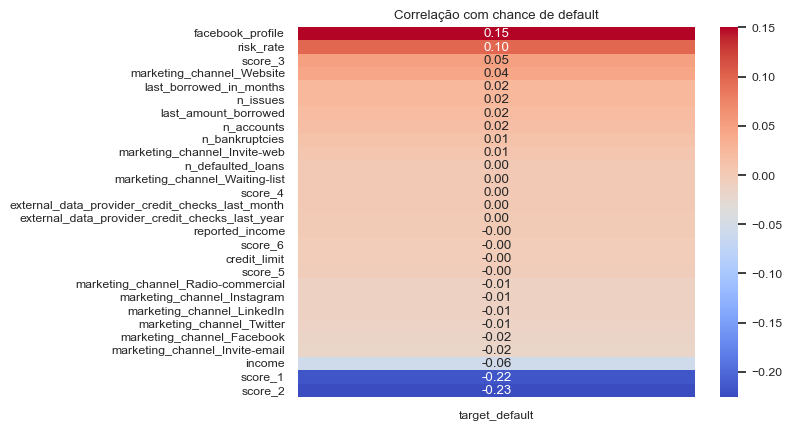

In [42]:
corr = encoded_df.corr()
target_corr = corr['target_default'].drop('target_default')

target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlação com chance de default')
plt.show()

As features com nível relevante de correlação são:
 - `score_1, score_2, income, facebook_profile, risk_rate e score_3` 

# Treinamento

In [43]:
# separar as variáveis independentes da variável alvo
X = encoded_df.drop('target_default', axis=1)
y = encoded_df['target_default']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Agruparemos o código para treinamento e cálculo das métricas em uma função.

In [44]:
modelos = [
      ('Logistic Regression', LogisticRegression(max_iter=1000)),
      ('Random Forest', RandomForestClassifier(random_state=42)),
      ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
      ('XG Boosting', xgb.XGBClassifier(random_state=42))
  ]

In [45]:
def encontra_melhor_modelo(modelos, X_train, y_train, metrica='roc_auc'):

  # Definindo os modelos
  
  # Treinamento dos modelos, avaliação e seleção.
  melhor_modelo = None
  melhor_score = -np.inf

  print("Performance dos Modelos:")
  for nome, modelo in modelos:
      modelo.fit(X_train, y_train)

      score = cross_validate(modelo, X_train, y_train, cv=5, scoring=['roc_auc','accuracy','balanced_accuracy', 'recall'], n_jobs=-1)

      metrica_valor = score['test_'+metrica].mean()

      print(f'{nome} - {metrica}: {metrica_valor:.4f}')    

      if metrica_valor > melhor_score:
          melhor_score = metrica_valor
          melhor_modelo = modelo
          melhor_modelo_nome = nome

  print(f"\nMelhor modelo: {melhor_modelo_nome} com {metrica}: {melhor_score:.4f}")
  
  return melhor_modelo

# Var Target Desbalanceada

Apesar da acurácia elevada, o modelo tende a generalizar a predição para que se adeque a categoria com maior predominância na base de dados (target = 0). Portanto acerta quase todos os casos de não default mas erra muito nas predições de default (target = 1)

Este efeito se deve ao desbalanceamento da variável target na amostra (84% de não default). Avaliaremos os modelos daqui em diante considerando o KS e AUC dos modelos, métricas essas que capturam quão bem o modelo diferencia uma classe de outra.

In [46]:
modelo_desbalanceado = encontra_melhor_modelo(modelos, X_train, y_train, 'recall')

Performance dos Modelos:


Logistic Regression - recall: 0.0478
Random Forest - recall: 0.0288
Gradient Boosting - recall: 0.0389
XG Boosting - recall: 0.0741

Melhor modelo: XG Boosting com recall: 0.0741


# Undersampling

Remove-se amostras aleatoriamente da classe majoritária (target_default = 0) para que a quantidade seja igual a da classe minoritária (target_default = 1).

In [47]:
# Contar classes
df_train = pd.concat([X_train, y_train], axis=1)
count_class_0, count_class_1 = df_train['target_default'].value_counts()

# Dividir por classes
df_class_0 = df_train[df_train['target_default'] == 0]
df_class_1 = df_train[df_train['target_default'] == 1]

In [48]:
df_class_0_under = df_class_0.sample(count_class_1, random_state=42)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_train_under['target_default'].value_counts())

Random under-sampling:
0.00    4829
1.00    4829
Name: target_default, dtype: int64


In [49]:
# separar as variáveis independentes da variável alvo
X_train_under = df_train_under.drop('target_default', axis=1)
y_train_under = df_train_under['target_default']

modelo_under = encontra_melhor_modelo(modelos, X_train_under, y_train_under, 'recall')

Performance dos Modelos:


Logistic Regression - recall: 0.6339
Random Forest - recall: 0.6318
Gradient Boosting - recall: 0.6480
XG Boosting - recall: 0.6231

Melhor modelo: Gradient Boosting com recall: 0.6480


# Oversampling

Duplica-se amostras aleatoriamente da classe minoritária (target_default = 1) para que a quantidade seja igual a da classe majoritária (target_default = 0).

In [50]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True, random_state= 42)
df_train_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_train_over['target_default'].value_counts())

Random over-sampling:
0.00    25334
1.00    25334
Name: target_default, dtype: int64


In [51]:
# separar as variáveis independentes da variável alvo
X_train_over = df_train_over.drop('target_default', axis=1)
y_train_over = df_train_over['target_default']

modelo_over = encontra_melhor_modelo(modelos, X_train_over, y_train_over, 'recall')

Performance dos Modelos:


Logistic Regression - recall: 0.6335
Random Forest - recall: 0.9855
Gradient Boosting - recall: 0.6742
XG Boosting - recall: 0.8440

Melhor modelo: Random Forest com recall: 0.9855


Os modelos de RandomForest e XGBoost apresentam sinais de overfiting. Consideraremos como vencedor o modelo de algoritmo Gradient Boosting.

In [52]:
modelo_over = encontra_melhor_modelo([('Gradient Boosting', GradientBoostingClassifier(random_state=42))], X_train_over, y_train_over, 'recall')

Performance dos Modelos:


Gradient Boosting - recall: 0.6742

Melhor modelo: Gradient Boosting com recall: 0.6742


# Feature Importances

Avaliaremos as feature importances do modelo com melhor desempenho, treinamento através de overfiting da amostra.

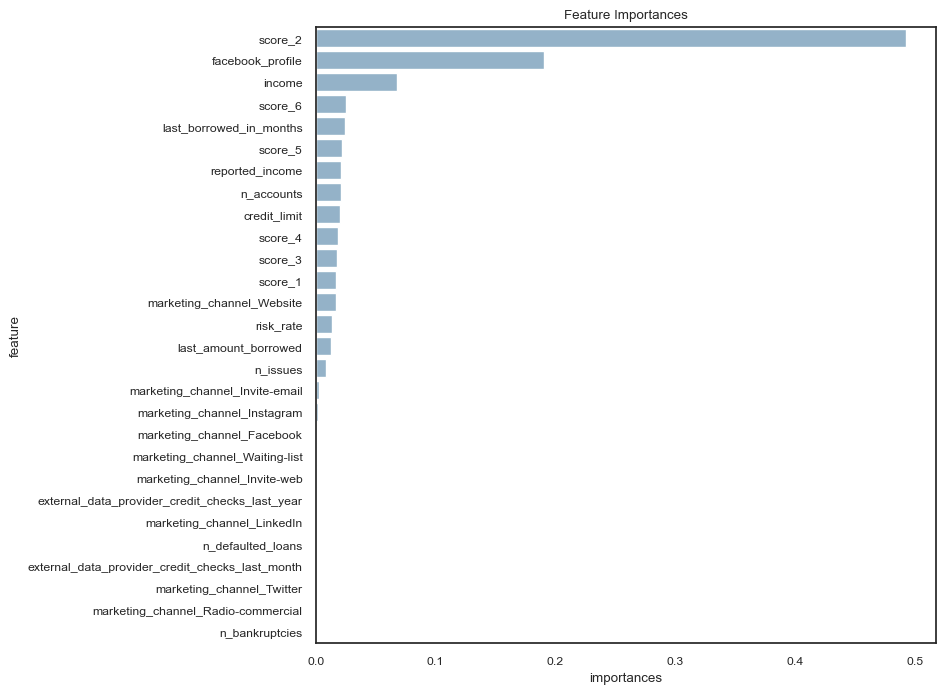

In [53]:
feat_names = modelo_over.feature_names_in_
importances = modelo_over.feature_importances_

df_importances = pd.DataFrame({'feature': feat_names, 'importances' : importances}).sort_values(by='importances', ascending=False)

fig, axis = plt.subplots(figsize=(8,8))
sns.barplot(x=df_importances['importances'], y=df_importances['feature'])
plt.title('Feature Importances')
plt.show()

# Testando Modelo OverSampled


Resultados na amostra de teste:
Acurácia: 0.6530.
Acurácia Balanceada: 0.6446.
Precisão: 0.2620.
Recall: 0.6322.
Especificidade: 0.6570.
F1: 0.3705.
ROC AUC: 0.6446
KS: 0.2892 (p-value: 0.0000)




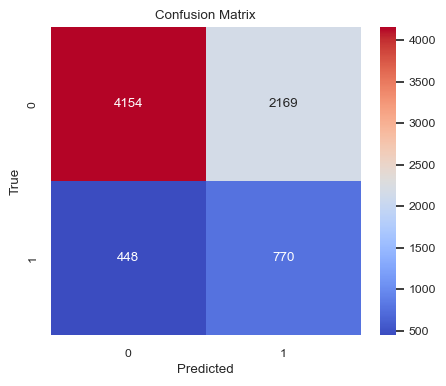

In [54]:
print(f'\nResultados na amostra de teste:')
y_pred = modelo_over.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
f1 = metrics.f1_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}.")
print(f"Acurácia Balanceada: {balanced_accuracy:.4f}.")
print(f"Precisão: {precision:.4f}.")
print(f"Recall: {recall:.4f}.")
print(f"Especificidade: {specificity:.4f}.")
print(f"F1: {f1:.4f}.")
print(f"ROC AUC: {roc_auc:.4f}")

#Calculando KS e AUC
df_ks = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
ks = ks_2samp(df_ks.loc[df_ks['y_test'] == 0, 'y_pred'], df_ks.loc[df_ks['y_test'] == 1, 'y_pred'])
print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.4f})")

print('\n')
# Generate the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

# Hyperparameter Tuning

Tuning do melhor modelo com amostra oversampled

In [63]:
#Parâmetros treinados anteriormente.
# parameters = {
#     'learning_rate':[0.001, 0.01, 0.1, 1],
#     'n_estimators':[500, 300, 100, 50],
#     'max_depth':[12, 6 , 3, 1],
#     'min_samples_split':[500, 100, 10, 5, 2],
#     'criterion':['friedman_mse', 'squared_error']
#     }

parameters = {
    'learning_rate':[0.01],
    'n_estimators':[300],
    'max_depth':[3],
    'min_samples_split':[2],
    'criterion':['friedman_mse']
    }

rand_search = GridSearchCV(GradientBoostingClassifier(random_state=42), parameters, scoring='recall', n_jobs=3, cv=5, verbose=0, return_train_score=True)
rand_search.fit(X_train_over, y_train_over)

modelo_over_tunado = rand_search.best_estimator_
rand_res = rand_search.cv_results_
modelo_over_tunado.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Testando Modelo Otimizado


Resultados na amostra de teste:
Acurácia: 0.6409.
Acurácia Balanceada: 0.6493.
Precisão: 0.2598.
Recall: 0.6617.
Especificidade: 0.6369.
F1: 0.3731.
ROC AUC: 0.6493
KS: 0.2986 (p-value: 0.0000)




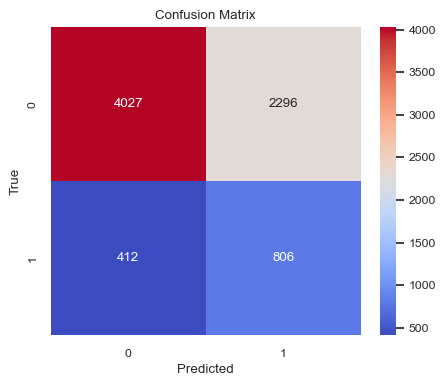

In [64]:
print(f'\nResultados na amostra de teste:')
y_pred = modelo_over_tunado.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
f1 = metrics.f1_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}.")
print(f"Acurácia Balanceada: {balanced_accuracy:.4f}.")
print(f"Precisão: {precision:.4f}.")
print(f"Recall: {recall:.4f}.")
print(f"Especificidade: {specificity:.4f}.")
print(f"F1: {f1:.4f}.")
print(f"ROC AUC: {roc_auc:.4f}")

#Calculando KS e AUC
df_ks = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
ks = ks_2samp(df_ks.loc[df_ks['y_test'] == 0, 'y_pred'], df_ks.loc[df_ks['y_test'] == 1, 'y_pred'])
print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.4f})")

print('\n')
# Generate the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

# Visualizando os Scores


Verificando faixas de probabilidade na amostra de treino.

In [92]:
df_train['y_proba'] = modelo_over_tunado.predict_proba(X_train)[:,1]
df_train['y_pred'] = modelo_over_tunado.predict(X_train)

n_bins = 10
df_train['faixa_score'] = pd.cut(df_train['y_proba'], bins=np.linspace(0, 1.0, 11, endpoint=True), retbins=True)[0]
print('\n', pd.crosstab(df_train['faixa_score'], df_train['target_default'], colnames=['target_default'], margins=True, normalize='index'))

cm_treino = metrics.confusion_matrix(df_train['target_default'], df_train['y_pred'])

print(f'\nDefault Real: {df_train["target_default"].mean():.0%}')
print(f'Default Predito: {df_train["y_pred"].mean():.0%}')

print('\nErro:')
print(f'Clientes bons com crédito negado: {(cm_treino[0][1]/cm_treino.sum()):.0%}')
print(f'Clientes ruins com crédito aprovado: {(cm_treino[1][0]/cm_treino.sum()):.0%}')


 target_default  0.0  1.0
faixa_score             
(0.1, 0.2]     0.98 0.02
(0.2, 0.3]     0.96 0.04
(0.3, 0.4]     0.91 0.09
(0.4, 0.5]     0.87 0.13
(0.5, 0.6]     0.81 0.19
(0.6, 0.7]     0.72 0.28
(0.7, 0.8]     0.56 0.44
(0.8, 0.9]     0.34 0.66
All            0.84 0.16

Default Real: 16%
Default Predito: 41%

Erro:
Clientes bons com crédito negado: 30%
Clientes ruins com crédito aprovado: 5%


Dado baixo nível de acertos do modelo temos um alto número de clientes que teriam crédito negado considerando o ponto de corte para o score em 50%.

# Decisão de Negócio

Qual seria o ponto de corte em que concedemos mais crédito e mantemos o apetite de risco atual da carteira de crédito?

Ponto de corte ajustado para 0.627, default predito em 16%.

Erro:
Clientes bons com crédito negado: 10%
Clientes ruins com crédito aprovado: 10%


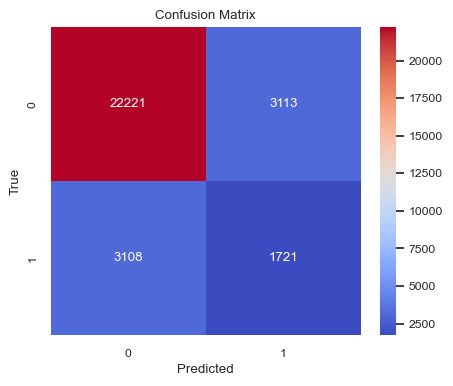

In [102]:
defaults = 0.16

for i in range(500,1000,1):
  pc = i/1000
  df_train['y_pred'] = 0
  df_train.loc[df_train['y_proba'] > pc, 'y_pred'] = 1

  default_temp = df_train['y_pred'].mean()

  if default_temp >= defaults:
     default_final = default_temp
     pc_final = pc

df_train['y_pred'] = 0
df_train.loc[df_train['y_proba'] > pc_final, 'y_pred'] = 1

cm = metrics.confusion_matrix(df_train['target_default'], df_train['y_pred'])

print(f'Ponto de corte ajustado para {pc_final}, default predito em {default_final:.0%}.')

print('\nErro:')
print(f'Clientes bons com crédito negado: {(cm[0][1]/cm.sum()):.0%}')
print(f'Clientes ruins com crédito aprovado: {(cm[1][0]/cm.sum()):.0%}')

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

Testando o novo ponto de corte na amostra teste.


Default Real: 16%
Default Predito: 16%

Erro:
Clientes bons com crédito negado: 10%
Clientes ruins com crédito aprovado: 10%

 target_default  0.0  1.0
faixa_score             
(0.1, 0.2]     0.97 0.03
(0.2, 0.3]     0.95 0.05
(0.3, 0.4]     0.91 0.09
(0.4, 0.5]     0.86 0.14
(0.5, 0.6]     0.82 0.18
(0.6, 0.7]     0.72 0.28
(0.7, 0.8]     0.55 0.45
(0.8, 0.9]     0.41 0.59
All            0.84 0.16


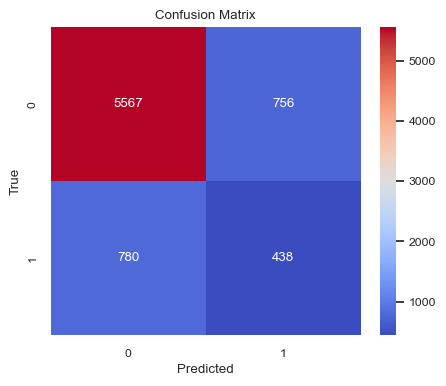

In [101]:
df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_proba'] = modelo_over_tunado.predict_proba(X_test)[:,1]

df_test['y_pred'] = 0
df_test.loc[df_test['y_proba'] > pc_final, 'y_pred'] = 1

cm_test = metrics.confusion_matrix(df_test['y_test'], df_test['y_pred'])

print(f'\nDefault Real: {cm_test[1].sum()/cm_test.sum():.0%}')
print(f'Default Predito: {(cm_test[0][1]+cm_test[1][1])/cm_test.sum():.0%}')

print('\nErro:')
print(f'Clientes bons com crédito negado: {(cm_test[0][1]/cm_test.sum()):.0%}')
print(f'Clientes ruins com crédito aprovado: {(cm_test[1][0]/cm_test.sum()):.0%}')

n_bins = 10
df_test['faixa_score'] = pd.cut(df_test['y_proba'], bins=np.linspace(0, 1.0, 11, endpoint=True), retbins=True)[0]
print('\n', pd.crosstab(df_test['faixa_score'], df_test['y_test'], colnames=['target_default'], margins=True, normalize='index'))

plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

# Conclusão

Na análise de correlação e valores de IV, encontramos cerca de 4 features com algum nível de relevância, `score_1, score_2, facebook_profile e risk_rate`. Avaliando a feature importance no treinamento do modelo, evidenciamos que as demais features pouco agregam nos modelos. Temos aqui a necessidade de inclusão de mais features no modelo, como por exemplo a utilização de outros produtos de crédito, tempo de atraso nos pagamentos, pagamento parcial de fatura, informações de open banking, etc.

Com relação aos problemas encontrados na amostra (desbalanceamento da variável target) foram testados dois métodos de regularização sendo eles: o UnderSampling que busca reduzir a amostra da classe majoritaria e o OverSampling que busca eequalizar a amostra da classe minoritária a majoritária. Com resultados melhores para o teino com amostra OverSampled.

Houve a tentativa de otimização dos hiperparâmetros porém não foram encontrados melhoras signficativas nos scores.

Foram obtidos resultados satisfatórios com relação ao modelo inicialmente proposto, tendo o KS e AUC aumentado consideravelmente.

* Desbalanceado - Melhor Modelo: XGBoost<br>
Recall: 7.41%

* UnderSampling - Melhor Modelo: Gradient Boosting<br>
Recall: 64.8%

* OverSampling - Melhor Modelo: Gradient Boosting<br>
Recall: 67.4%

Estudando as faixas de probabilidade geradas, podemos verificar uma grande proporção da amostra de "bons clientes" sendo marcados como "ruins", desta forma o negócio deixaria dinheiro na mesa. Foi proposto um novo ponto de corte que concede mais crédito (e consequentemente também para clientes que podem entrar em default) mas que mantém a proporção de crédito ruim ou seja mantemos o apetite de risco.

* Ponto de Corte > 0.5<br><br>
Default Predito: 41%<br>
Clientes bons com crédito negado: 30%<br>
Clientes ruins com crédito aprovado: 5%

* Ponto de Corte > 0.627<br><br>
Default Predito: 16%<br>
Clientes bons com crédito negado: 10%<br>
Clientes ruins com crédito aprovado: 10%


